# Looking at how we can fit discrete models with variational inference 

This code mainly looks at simpler problem of finding a discrete Q which approximates a fixed, known discrete P by minimizing KL divergence.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from multiple_subject_vae_2 import BernoulliCondDistribution
from multiple_subject_vae_2 import CondSpikeSlabDistribution
from multiple_subject_vae_2 import CondGaussianDistribution
from multiple_subject_vae_2 import ConstantRealFcn
from multiple_subject_vae_2 import ConstantLowerBoundedFcn
from multiple_subject_vae_2 import ConstantLowerUpperBoundedFcn
from multiple_subject_vae_2 import LogBumpFcn
from multiple_subject_vae_2 import LogProbTanhFcn
from multiple_subject_vae_2 import make_bernoulli_vi_debug_figure
from multiple_subject_vae_2 import visualize_bernoulli_distribution
from multiple_subject_vae_2 import visualize_spike_slab_distribution

## Generate neuron properties for all of the simulations below

In [39]:
# Properties of neurons we condition on 
n_neurons = 2000
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Here we find a q distribution which approximates a fixed p by minimizing kl divergencve

In [42]:
# Basic Bernoulli distributions
#p = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#q = BernoulliCondDistribution(ConstantLowerUpperBoundedFcn(1, lower_bound=-10.0, upper_bound=0.0))
#p.log_prob_fcn.v.data = torch.tensor([2.0])

# Bernoulli distributions which change probabilities condition on neuron properties
p_log_prob_fcn = LogBumpFcn(2)
p_log_prob_fcn.log_gain_vl.v.data = torch.tensor([10.0])
p_log_prob_fcn.ctr.data = torch.tensor([.25, .25])
p_log_prob_fcn.ctr_stds.v.data = torch.tensor([-4.0, -4.0])
p = BernoulliCondDistribution(p_log_prob_fcn)

q_log_prob_fcn = LogBumpFcn(2, f_type='exp')
q_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2.0])
q_log_prob_fcn.log_gain_vl.lower_bound = np.log(.002)
q_log_prob_fcn.log_gain_vl.v.data = torch.tensor(200.0)

q = BernoulliCondDistribution(q_log_prob_fcn)

c_net = torch.nn.Sequential(torch.nn.Linear(2, 2), torch.nn.ReLU(), 
                            torch.nn.Linear(2, 10), torch.nn.ReLU(), 
                            torch.nn.Linear(10, 10), torch.nn.ReLU(), 
                            torch.nn.Linear(10, 10), torch.nn.ReLU(),
                            torch.nn.Linear(10,1))

it: 0, o: -94423.42 , c: 123794570.0
it: 2000, o: -17.90284 , c: 65.45274
it: 4000, o: -23.10374 , c: 35.818745
it: 6000, o: -3.7667398 , c: 2.3546343
it: 8000, o: -0.3471821 , c: 0.50909805
it: 10000, o: -0.62145656 , c: 0.20449626
it: 12000, o: -0.24303134 , c: 0.01450738
it: 14000, o: -0.02500461 , c: 0.0017444511
it: 16000, o: -54.966297 , c: 3468.5916
it: 18000, o: 0.00050606055 , c: 0.0017078052


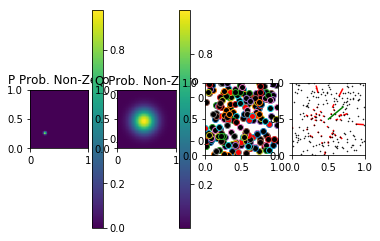

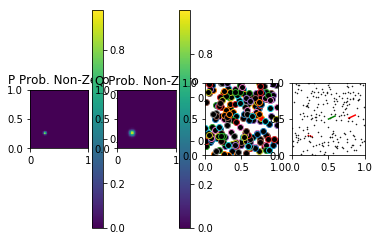

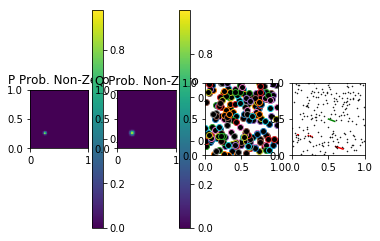

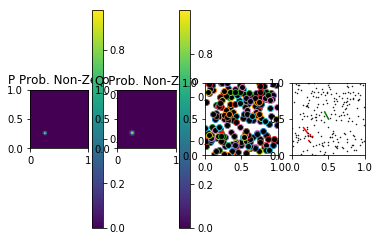

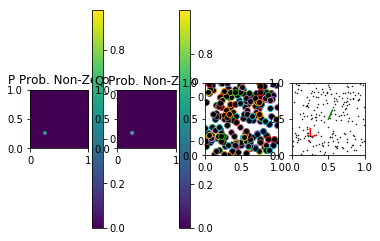

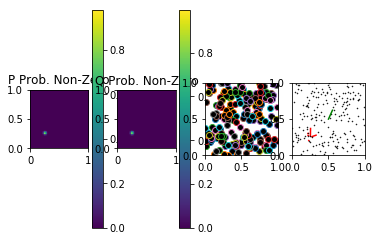

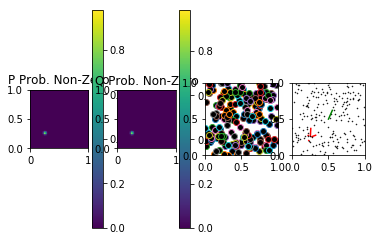

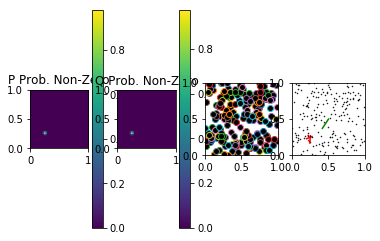

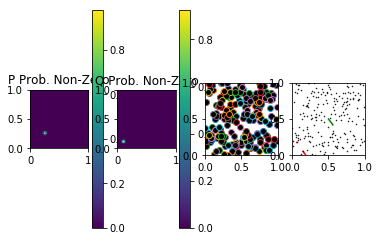

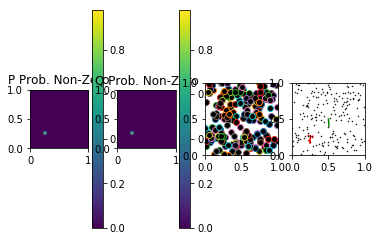

In [43]:
## Fit q to p with variational inference

#params = q.parameters()

enforce_borders = True
lower_border = 0.01
upper_border = 0.99

params = [{'params': q.log_prob_fcn.ctr_stds.parameters(), 'lr': .01},
          {'params': q.log_prob_fcn.log_gain_vl.parameters(), 'lr': .01},
          {'params': q.log_prob_fcn.ctr, 'lr': .01}]

optim = torch.optim.Adam(params=params, lr=.01)
c_optim = torch.optim.Adam(params=c_net.parameters(), lr=.01)

n_its = 20000
batch_size = n_neurons # Set this to more than the number of samples to have more Q samples than neurons
o_vls = np.zeros(n_its)
sum_l = np.zeros(n_its)
l_log = [None]*n_its

for i in range(n_its):
    optim.zero_grad()
    
    with torch.no_grad():
        smp_inds = np.random.choice(neuron_props.shape[0], batch_size)
        smp_i = q.sample(neuron_props[smp_inds,:])
        l = q.log_prob(neuron_props[smp_inds,:], smp_i) - p.log_prob(neuron_props[smp_inds,:], smp_i)
        sum_l[i] = torch.sum(l).numpy()
    
    c = c_net(neuron_props[smp_inds,:]).squeeze()
    
    o = torch.sum((l- c.detach())*q.log_prob(neuron_props[smp_inds,:], smp_i))
    #o = torch.sum(l*q.log_prob(neuron_props[smp_inds,:], smp_i))
    
    o.backward()
    
    optim.step();
    
    # Update c
    c_optim.zero_grad()
    c_obj = torch.sum((l - c)**2)
    c_obj.backward()
    c_optim.step()
    
    
    if enforce_borders:
        with torch.no_grad():
            cur_c = q.log_prob_fcn.ctr.data.detach().numpy()
            cur_c[0] = np.min([np.max([cur_c[0], lower_border]), upper_border])
            cur_c[1] = np.min([np.max([cur_c[0], lower_border]), upper_border])
            q.log_prob_fcn.ctr.data = torch.from_numpy(cur_c)
    
    record_o = o.detach().numpy()
    record_c = c_obj.detach().numpy()
    if i % 2000 == 0:
        print('it: ' + str(i) + ', o: ' + str(record_o), ', c: ' + str(record_c))
        j_range = np.arange(0, neuron_props.shape[0], 10)
        l_d = l.detach().numpy()
        smp_i_plot = smp_i.detach().numpy()
        
        grads = np.zeros([len(j_range), 2])
        for j_i, j in enumerate(j_range):
            optim.zero_grad()
            with torch.no_grad():
                l_j = (q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)) - 
                        p.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].unsqueeze(0)))
            
            o_j = l_j*q.log_prob(neuron_props[j, :].unsqueeze(0), smp_i[j].reshape([1]))
            o_j.backward()
            grads[j_i,:] = q.log_prob_fcn.ctr.grad.data.numpy().copy()
        
        make_bernoulli_vi_debug_figure(q, p, smp_x=neuron_props[j_range], smp_y=smp_i_plot[j_range],
                                       grads=grads)

    o_vls[i] = record_o
    

## Generate data from one spike and slab distribution and fit another with maximum likelihood

We use the same ground truth data and distribution we used with the variational inference approach

In [ ]:
# Ground truth distribution 
spike_log_prob_fcn = LogBumpFcn(2)
spike_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2.0])
spike_dist = BernoulliCondDistribution(log_prob_fcn=spike_log_prob_fcn)



slab_mn_fcn = ConstantRealFcn(n_dims=1)
slab_mn_fcn.vl.data = torch.tensor([5.0])
slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
slab_std_fcn.log_vl.data = torch.tensor([0.0])
slab_dist = CondGaussianDistribution(slab_mn_fcn, slab_std_fcn)

spike_slab_dist = CondSpikeSlabDistribution(spike_dist=spike_dist, slab_dist=slab_dist, d=1)

In [ ]:
# Get samples for true distribution
with torch.no_grad():
    support, nz_vls = spike_slab_dist.sample(neuron_props)

    y = torch.zeros(len(support))
    y[support] = nz_vls
    y = y.unsqueeze(1)

In [ ]:
# Fitted distribution 

f_spike_log_prob_fcn = LogBumpFcn(2)
f_spike_dist = BernoulliCondDistribution(f_spike_log_prob_fcn)

f_slab_mn_fcn = ConstantRealFcn(n_dims=1)
f_slab_std_fcn = ConstantLowerBoundedFcn(n_dims=1, lower_bound=.05)
f_slab_std_fcn.log_vl.data = torch.tensor([5.0])
f_slab_dist = CondGaussianDistribution(f_slab_mn_fcn, f_slab_std_fcn)

f_spike_slab_dist = CondSpikeSlabDistribution(spike_dist=f_spike_dist, slab_dist=f_slab_dist,
                                              d=1)


In [ ]:
## Fit spike slab distribution with maximum likelihood

params = f_spike_slab_dist.parameters()
optim = torch.optim.Adam(params=params, lr=.01)

for i in range(2000): 
    optim.zero_grad()
    
    nll = -1*torch.sum(f_spike_slab_dist.log_prob(neuron_props, y))
    nll.backward()
    optim.step()
    if i % 200 == 0:
        print('i:' + str(i) + ', nll: ' +  str(nll.detach()))

In [ ]:
# Visualize True distribution
visualize_spike_slab_distribution(spike_slab_dist, smp_x=neuron_props, smp_y=y.squeeze())

In [ ]:
# Visualize Fit distribution
visualize_spike_slab_distribution(f_spike_slab_dist)